In [2]:
!pip install yfinance stable-baselines3 gym numpy pandas matplotlib
# !pip install ta-lib

In [8]:
import yfinance as yf
import pandas as pd

tickers = ['GOOG','AAPL','TSLA']

def get_data(tickers):
    data = {}
    for ticker in tickers:
        df = yf.download(ticker,start='2009-01-01',end='2020-05-08')
        data[ticker] = df
    return data

stock_df = get_data(tickers)

print(stock_df)

for ticker,df in stock_df.items():
    df.to_csv(f'{ticker}.csv')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

{'GOOG':                  Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2009-01-02   7.686190   8.015456   7.608980   8.003003   7.983397  144961322
2009-01-05   7.995033   8.250077   7.845593   8.170624   8.150607  196293007
2009-01-06   8.293414   8.488184   8.129279   8.320313   8.299930  257971329
2009-01-07   8.177349   8.241857   7.938993   8.020188   8.000541  180453860
2009-01-08   7.927287   8.099391   7.903874   8.099391   8.079549  144567852
...               ...        ...        ...        ...        ...        ...
2020-05-01  66.425003  67.603500  65.550003  66.030502  65.868736   41450000
2020-05-04  65.411499  66.383003  64.949997  66.339996  66.177475   30080000
2020-05-05  66.896004  68.696999  66.873001  67.555496  67.389999   33030000
2020-05-06  68.084503  68.556000  67.364502  67.364998  67.199966   24308000
2020-05-07  68.296997  68.879997  67.763496  68.627998  68.459877  

In [9]:
benchmark = '^DJI'
stock_data = {}
for ticker in tickers:
    df = pd.read_csv(f'{ticker}.csv', index_col='Date', parse_dates=True)
    stock_data[ticker] = df


# split the data into training, validation and test sets
training_data_time_range = ('2009-01-01', '2015-12-31')
validation_data_time_range = ('2016-01-01', '2016-12-31')
test_data_time_range = ('2017-01-01', '2020-05-08')

# split the data into training, validation and test sets
training_data = {}
validation_data = {}
test_data = {}

for ticker, df in stock_data.items():
    training_data[ticker] = df.loc[training_data_time_range[0]:training_data_time_range[1]]
    validation_data[ticker] = df.loc[validation_data_time_range[0]:validation_data_time_range[1]]
    test_data[ticker] = df.loc[test_data_time_range[0]:test_data_time_range[1]]

# print shape of training, validation and test data
ticker = 'AAPL'
print(f'Training data shape for {ticker}: {training_data[ticker].shape}')
print(f'Validation data shape for {ticker}: {validation_data[ticker].shape}')
print(f'Test data shape for {ticker}: {test_data[ticker].shape}')

# Display the first 5 rows of the data
stock_data['AAPL'].head()


Training data shape for AAPL: (1762, 6)
Validation data shape for AAPL: (252, 6)
Test data shape for AAPL: (842, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,3.067143,3.251429,3.041429,3.241071,2.737005,746015200
2009-01-05,3.327500,3.435000,3.311071,3.377857,2.852516,1181608400
2009-01-06,3.426786,3.470357,3.299643,3.322143,2.805467,1289310400
2009-01-07,3.278929,3.303571,3.223571,3.250357,2.744847,753048800
2009-01-08,3.229643,3.326786,3.215714,3.310714,2.795816,673500800


In [17]:
stock_data['AAPL'].columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

# Compute the technical indicators RSI,MACD,ADX

In [15]:
import numpy as np
import pandas as pd

def compute_rsi(df,n):
    df = df.copy()
    df['close_diff'] = df['Close'].diff().dropna()
    # df.dropna(inplace=True)
    df['gain'] = df['close_diff'].apply(lambda x: x if x > 0 else 0)
    df['loss'] = df['close_diff'].apply(lambda x: -x if x < 0 else 0)
    alpha = 1/n

    for i in range(n,len(df)):
        if i == n:
            df.loc[df.index[i],'avg_gain'] = df['gain'].rolling(window=n,min_periods=n).mean().iloc[n-1]
            df.loc[df.index[i],'avg_loss'] = df['loss'].rolling(window=n,min_periods=n).mean().iloc[n-1]
        else:
            df.loc[df.index[i],'avg_gain'] = (alpha * df.loc[df.index[i],'gain']) + (1 - alpha)*(df.loc[df.index[i-1],'avg_gain'])
            df.loc[df.index[i],'avg_loss'] = (alpha * df.loc[df.index[i],'loss']) + (1 - alpha)*(df.loc[df.index[i-1],'avg_loss'])

    df['rs'] = df['avg_gain'] / df['avg_loss']
    df['RSI'] = 100 - (100/(1 + df['rs']))
    return df


def compute_adx(df,n):
    df = df.copy()
    df['tr'] = np.maximum.reduce([df['High'] - df['Low'],
                  abs(df['High'] - df['Close'].shift(1)),
                  abs(df['Low'] - df['Close'].shift(1))])
    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                    np.maximum(df['High'] - df['High'].shift(1), 0),
                    0)

    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                        np.maximum(df['Low'].shift(1) - df['Low'], 0),
                        0)

    for i in range(len(df)):
        if i == n:
            df.loc[df.index[i-1], 'tr_smoothed'] = df['tr'][:i].sum()
            df.loc[df.index[i-1], '+DM_smoothed'] = df['+DM'][:i].sum()
            df.loc[df.index[i-1], '-DM_smoothed'] = df['-DM'][:i].sum()

    for i in range(n,len(df)):
        df.loc[df.index[i], 'tr_smoothed'] = (df.loc[df.index[i-1], 'tr_smoothed'] - (df.loc[df.index[i-1], 'tr_smoothed'] / n)) + df.loc[df.index[i], 'tr']
        df.loc[df.index[i], '+DM_smoothed'] = (df.loc[df.index[i-1], '+DM_smoothed'] - (df.loc[df.index[i-1], '+DM_smoothed'] / n)) + df.loc[df.index[i], '+DM']
        df.loc[df.index[i], '-DM_smoothed'] = (df.loc[df.index[i-1], '-DM_smoothed'] - (df.loc[df.index[i-1], '-DM_smoothed'] / n)) + df.loc[df.index[i], '-DM']

    df['DI+'] = 100*(df['+DM_smoothed'] / df['tr_smoothed'])
    df['DI-'] = 100*(df['-DM_smoothed'] / df['tr_smoothed'])
    df['DX'] = (abs(df['DI+'] - df['DI-']) / (df['DI+'] + df['DI-'])) * 100
    df.loc[df.index[n*2-1], 'ADX'] = df['DX'][n:n*2].mean()

    for i in range(n*2, len(df)):
        df.loc[df.index[i], 'ADX'] = (
            (df.loc[df.index[i-1], 'ADX'] * (n - 1) + df.loc[df.index[i], 'DX']) / n
        )

    return df

def compute_ema(df,n,column_name):
    df = df.copy()
    df[column_name] = np.nan
    df.loc[df.index[n-1], column_name] = df['Close'][:n].mean()
    multiplier = 2 / (n + 1)
    for i in range(n,len(df)):
        df.loc[df.index[i],column_name] = (df.loc[df.index[i],'Close'] - df.loc[df.index[i - 1],column_name]) * multiplier + df.loc[df.index[i - 1],column_name]
    return df

def compute_signal(df, n):
    df = df.copy()
    df['Signal'] = np.nan

    first_valid_index = df['MACD'].first_valid_index()
    if first_valid_index is None:
        raise ValueError("MACD column contains only NaN values.")

    start_index = df.index.get_loc(first_valid_index) + n - 1
    if start_index < len(df):
        df.loc[df.index[start_index], 'Signal'] = df['MACD'].iloc[start_index - n + 1:start_index + 1].mean()
    multiplier = 2 / (n + 1)
    for i in range(start_index + 1, len(df)):
        df.loc[df.index[i], 'Signal'] = ((df.loc[df.index[i], 'MACD'] - df.loc[df.index[i - 1], 'Signal'])
                                          * multiplier) + df.loc[df.index[i - 1], 'Signal']
    return df

def compute_cci(df,n):
    df = df.copy()
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = tp.rolling(window=20).mean()
    mean_dev = tp.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))
    df['CCI'] = (tp - sma_tp) / (0.015 * mean_dev)
    return df


def compute_all_indicators(df):
    df = df.copy()

    # Compute EMA indicators
    df = compute_ema(df, 12, 'fast_ma')
    df = compute_ema(df, 26, 'slow_ma')
    df['MACD'] = df['fast_ma'] - df['slow_ma']

    # Compute Signal Line for MACD
    df = compute_signal(df, 9)
    df['macd_histogram'] = df['MACD'] - df['Signal']

    # Compute ADX
    df = compute_adx(df, 14)

    # Compute RSI
    df = compute_rsi(df, 14)

    # Compute CCI
    df = compute_cci(df, 20)

    df.dropna(inplace=True)

    df = df[['Open', 'High', 'Low', 'Close', 'Volume', 'MACD', 'Signal', 'RSI', 'CCI', 'ADX']]


    return df


In [16]:
for ticker, df in training_data.items():
    training_data[ticker] = compute_all_indicators(df)

# add technical indicators to the validation data for each stock
for ticker, df in validation_data.items():
    validation_data[ticker] = compute_all_indicators(df)

# add technical indicators to the test data for each stock
for ticker, df in test_data.items():
    test_data[ticker] = compute_all_indicators(df)

# print the first 5 rows of the data
print('Shape of training data for AAPL:', training_data['AAPL'].shape)
print('Shape of validation data for AAPL:', validation_data['AAPL'].shape)
print('Shape of test data for AAPL:', test_data['AAPL'].shape)


Shape of training data for AAPL: (1729, 10)
Shape of validation data for AAPL: (219, 10)
Shape of test data for AAPL: (809, 10)


# Creating a Trading environment

In [27]:
import gymnasium as gym
from gymnasium import spaces

class StockTradingEnv(gym.Env):
    metadata = {'render_modes':['human']}

    def __init__(self,stock_data,transaction_cost_percentage=0.005):
        super(StockTradingEnv,self).__init__()

        self.stock_data = {ticker:df for ticker,df in stock_data.items() if not df.empty}
        self.tickers = list(self.stock_data.keys())

        if not self.tickers:
            raise ValueError("All provided stock data is empty")

        sample_df = next(iter(self.stock_data.values()))
        self.n_features = len(sample_df.columns)
        # Define the action space: Buy (1), Hold (0), or Sell (-1) for each stock
        self.action_space = spaces.Box(low=-1, high=1, shape=(len(self.tickers),), dtype=np.float32)

        # Define the observation space, which includes:
        # - Price data for each stock (n_features * len(tickers))
        # - Account balance (1)
        # - Number of shares held for each stock (len(tickers))
        # - Net worth (1)
        # - Maximum net worth (1)
        # - Current step (1)

        self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_shape,), dtype=np.float32)

        # Initialize account-related variables
        self.initial_balance = 1000  # Starting balance
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}

         # Set the current step to zero (beginning of the data)
        self.current_step = 0

        # Determine the maximum number of steps based on the shortest stock data length
        self.max_steps = max(0, min(len(df) for df in self.stock_data.values()) - 1)

        # Set the transaction cost percentage for buying/selling stocks
        self.transaction_cost_percent = transaction_cost_percentage

    def reset(self, seed=None, options=None):
        # Reset the environment state
        super().reset(seed=seed)
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.shares_held = {ticker: 0 for ticker in self.tickers}
        self.total_shares_sold = {ticker: 0 for ticker in self.tickers}
        self.total_sales_value = {ticker: 0 for ticker in self.tickers}
        self.current_step = 0

        # Return the first observation and an empty info dictionary
        return self._next_observation(), {}

    def _next_observation(self):
        frame = np.zeros(self.obs_shape)

        # Add stock data for each ticker at the current step
        idx = 0
        for ticker in self.tickers:
            df = self.stock_data[ticker]
            # Use current step data if available; otherwise, use the last available data
            if self.current_step < len(df):
                frame[idx:idx + self.n_features] = df.iloc[self.current_step].values
            elif len(df) > 0:
                frame[idx:idx + self.n_features] = df.iloc[-1].values
            idx += self.n_features

        # Add account information to the observation frame
        frame[-4 - len(self.tickers)] = self.balance  # Account balance
        frame[-3 - len(self.tickers):-3] = [self.shares_held[ticker] for ticker in self.tickers]  # Shares held for each stock
        frame[-3] = self.net_worth  # Current net worth
        frame[-2] = self.max_net_worth  # Maximum net worth reached so far
        frame[-1] = self.current_step  # Current step in the simulation

        return frame

    def step(self, actions):
        # Advance the simulation step
        self.current_step += 1

        # If the maximum number of steps has been reached, end the episode
        if self.current_step > self.max_steps:
            return self._next_observation(), 0, True, False, {}

        # Dictionary to keep track of current prices
        current_prices = {}

        # Process each action for each ticker
        for i, ticker in enumerate(self.tickers):
            # Get the current price of the stock
            current_prices[ticker] = self.stock_data[ticker].iloc[self.current_step]['Close']
            action = actions[i]

            if action > 0:  # Buy action
                # Calculate the number of shares to buy
                shares_to_buy = int(self.balance * action / current_prices[ticker])
                cost = shares_to_buy * current_prices[ticker]
                transaction_cost = cost * self.transaction_cost_percent
                # Update account balance and shares held
                self.balance -= (cost + transaction_cost)
                self.shares_held[ticker] += shares_to_buy

            elif action < 0:  # Sell action
                # Calculate the number of shares to sell
                shares_to_sell = int(self.shares_held[ticker] * abs(action))
                sale = shares_to_sell * current_prices[ticker]
                transaction_cost = sale * self.transaction_cost_percent
                # Update account balance and shares held
                self.balance += (sale - transaction_cost)
                self.shares_held[ticker] -= shares_to_sell
                # Track the number of shares sold and total sales value
                self.total_shares_sold[ticker] += shares_to_sell
                self.total_sales_value[ticker] += sale

        # Update net worth (account balance + value of held stocks)
        self.net_worth = self.balance + sum(self.shares_held[ticker] * current_prices[ticker] for ticker in self.tickers)
        # Update the maximum net worth reached
        self.max_net_worth = max(self.net_worth, self.max_net_worth)
        # Calculate the reward (change in net worth)
        reward = self.net_worth - self.initial_balance
        # Check if the episode should end (if net worth drops to zero or maximum steps reached)
        done = self.net_worth <= 0 or self.current_step >= self.max_steps

        # Return the next observation, reward, done flag, truncated flag (False), and an empty info dictionary
        obs = self._next_observation()
        return obs, reward, done, False, {}

    def render(self, mode='human'):
        # Display the current step, balance, shares held, net worth, and profit
        profit = self.net_worth - self.initial_balance
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance:.2f}')
        for ticker in self.tickers:
            print(f'{ticker} Shares held: {self.shares_held[ticker]}')
        print(f'Net worth: {self.net_worth:.2f}')
        print(f'Profit: {profit:.2f}')

    def close(self):
        # No special cleanup is required here
        pass

def update_stock_data(self, new_stock_data, transaction_cost_percent=None):
    """
    Update the environment with new stock data.

    Parameters:
    new_stock_data (dict): Dictionary containing new stock data,
                           with keys as stock tickers and values as DataFrames.
    transaction_cost_percent (float, optional): New transaction cost percentage.
    """
    # Remove empty DataFrames
    self.stock_data = {ticker: df for ticker, df in new_stock_data.items() if not df.empty}
    self.tickers = list(self.stock_data.keys())

    # Check if there is any valid stock data
    if not self.tickers:
        raise ValueError("All new stock data are empty")

    # Update the number of features based on the new data
    sample_df = next(iter(self.stock_data.values()))
    self.n_features = len(sample_df.columns)

    # Update the observation space based on the new number of tickers and features
    self.obs_shape = self.n_features * len(self.tickers) + 2 + len(self.tickers) + 2
    self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.obs_shape,), dtype=np.float32)

    # Update the maximum number of steps based on the new data length
    self.max_steps = max(0, min(len(df) for df in self.stock_data.values()) - 1)

    # Update the transaction cost percentage if a new value is provided
    if transaction_cost_percent is not None:
        self.transaction_cost_percent = transaction_cost_percent

    # Reset the environment to apply the changes
    self.reset()

    print(f"The environment has been updated with {len(self.tickers)} new stocks.")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Training Model - Ensemble + PPO + A2C + DDPG + SAC + TD3

In [19]:
from stable_baselines3 import PPO, A2C, DDPG, SAC, TD3
from stable_baselines3.common.vec_env import DummyVecEnv

# Define Ensemble Agent
class EnsembleAgent:
    def __init__(self, ppo_model, a2c_model, ddpg_model, sac_model, td3_model):
        self.ppo_model = ppo_model
        self.a2c_model = a2c_model
        self.ddpg_model = ddpg_model
        self.sac_model = sac_model
        self.td3_model = td3_model

    def predict(self, obs):
        ppo_action, _ = self.ppo_model.predict(obs)
        a2c_action, _ = self.a2c_model.predict(obs)
        ddpg_action, _ = self.ddpg_model.predict(obs)
        sac_action, _ = self.sac_model.predict(obs)
        td3_action, _ = self.td3_model.predict(obs)

        # Average the actions
        ensemble_action = np.mean([ppo_action, a2c_action, ddpg_action, sac_action, td3_action], axis=0)
        return ensemble_action

# Define PPO Agent
class PPOAgent:
    def __init__(self, env, total_timesteps):
        self.model = PPO("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)

    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action

# Define A2C Agent
class A2CAgent:
    def __init__(self, env, total_timesteps):
        self.model = A2C("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)

    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action

# Define DDPG Agent
class DDPGAgent:
    def __init__(self, env, total_timesteps):
        self.model = DDPG("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)

    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action

# Define SAC Agent
class SACAgent:
    def __init__(self, env, total_timesteps):
        self.model = SAC("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)

    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action

# Define TD3 Agent
class TD3Agent:
    def __init__(self, env, total_timesteps):
        self.model = TD3("MlpPolicy", env, verbose=1)
        self.model.learn(total_timesteps=total_timesteps)

    def predict(self, obs):
        action, _ = self.model.predict(obs)
        return action

# Create environment and Train agents PPO, A2C, DDPG, SAC, TD3 and Ensemble

In [20]:
def create_env_and_train_agents(data, total_timesteps):
    # Create the environment using DummyVecEnv with training data
    env = DummyVecEnv([lambda: StockTradingEnv(data)])

    # Train PPO Agent
    ppo_agent = PPOAgent(env, total_timesteps)

    # Train A2C Agent
    a2c_agent = A2CAgent(env, total_timesteps)

    # Train DDPG Agent
    ddpg_agent = DDPGAgent(env, total_timesteps)

    # Train SAC Agent
    sac_agent = SACAgent(env, total_timesteps)

    # Train TD3 Agent
    td3_agent = TD3Agent(env, total_timesteps)

    # Train the ensemble agent
    ensemble_agent = EnsembleAgent(ppo_agent.model, a2c_agent.model, ddpg_agent.model, sac_agent.model, td3_agent.model)

    return env, ppo_agent, a2c_agent, ddpg_agent, sac_agent, td3_agent, ensemble_agent


In [22]:
# Function to visualize portfolio changes
import matplotlib.pyplot as plt

def visualize_portfolio(steps, balances, net_worths, shares_held, tickers, show_balance=True, show_net_worth=True, show_shares_held=True):
    fig, axs = plt.subplots(3, figsize=(12, 18))

    # Plot the balance
    if show_balance:
        axs[0].plot(steps, balances, label='Balance')
        axs[0].set_title('Balance Over Time')
        axs[0].set_xlabel('Steps')
        axs[0].set_ylabel('Balance')
        axs[0].legend()

    # Plot the net worth
    if show_net_worth:
        axs[1].plot(steps, net_worths, label='Net Worth', color='orange')
        axs[1].set_title('Net Worth Over Time')
        axs[1].set_xlabel('Steps')
        axs[1].set_ylabel('Net Worth')
        axs[1].legend()

    # Plot the shares held
    if show_shares_held:
        for ticker in tickers:
            axs[2].plot(steps, shares_held[ticker], label=f'Shares Held: {ticker}')
        axs[2].set_title('Shares Held Over Time')
        axs[2].set_xlabel('Steps')
        axs[2].set_ylabel('Shares Held')
        axs[2].legend()

    plt.tight_layout()
    plt.show()

# function to visualize the portfolio net worth
def visualize_portfolio_net_worth(steps, net_worths):
    plt.figure(figsize=(12, 6))
    plt.plot(steps, net_worths, label='Net Worth', color='orange')
    plt.title('Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.show()

# function to visualize the multiple portfolio net worths ( same chart )
def visualize_multiple_portfolio_net_worth(steps, net_worths_list, labels):
    plt.figure(figsize=(12, 6))
    for i, net_worths in enumerate(net_worths_list):
        plt.plot(steps, net_worths, label=labels[i])
    plt.title('Net Worth Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Net Worth')
    plt.legend()
    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
def test_agent(env, agent, stock_data, n_tests=1000, visualize=False):
    """
    Test a single agent and track performance metrics, with an option to visualize the results.

    Parameters:
    - env: The trading environment.
    - agent: The agent to be tested.
    - stock_data: Data for the stocks in the environment.
    - n_tests: Number of tests to run (default: 1000).
    - visualize: Boolean flag to enable or disable visualization (default: False).

    Returns:
    - A dictionary containing steps, balances, net worths, and shares held.
    """
    # Initialize metrics tracking
    metrics = {
        'steps': [],
        'balances': [],
        'net_worths': [],
        'shares_held': {ticker: [] for ticker in stock_data.keys()}
    }

    # Reset the environment before starting the tests
    obs = env.reset()

    for i in range(n_tests):
        metrics['steps'].append(i)
        action = agent.predict(obs)
        obs, rewards, dones, infos = env.step(action)
        if visualize:
            env.render()

        # Track metrics
        metrics['balances'].append(env.get_attr('balance')[0])
        metrics['net_worths'].append(env.get_attr('net_worth')[0])
        env_shares_held = env.get_attr('shares_held')[0]

        # Update shares held for each ticker
        for ticker in stock_data.keys():
            if ticker in env_shares_held:
                metrics['shares_held'][ticker].append(env_shares_held[ticker])
            else:
                metrics['shares_held'][ticker].append(0)  # Append 0 if ticker is not found

        if dones:
            obs = env.reset()

    return metrics


In [24]:
def test_and_visualize_agents(env, agents, training_data, n_tests=1000):
    metrics = {}
    for agent_name, agent in agents.items():
        print(f"Testing {agent_name}...")
        metrics[agent_name] = test_agent(env, agent, training_data, n_tests=n_tests, visualize=True)
        print(f"Done testing {agent_name}!")

    print('-'*50)
    print('All agents tested!')
    print('-'*50)

    # Extract net worths for visualization
    net_worths = [metrics[agent_name]['net_worths'] for agent_name in agents.keys()]
    steps = next(iter(metrics.values()))['steps']  # Assuming all agents have the same step count for simplicity

    # Visualize the performance metrics of multiple agents
    visualize_multiple_portfolio_net_worth(steps, net_worths, list(agents.keys()))


In [28]:
def compare_and_plot_agents(agents_metrics, labels, risk_free_rate=0.0):
    # Function to compare returns, standard deviation, and sharpe ratio of agents
    def compare_agents(agents_metrics, labels):
        returns = []
        stds = []
        sharpe_ratios = []

        for metrics in agents_metrics:
            net_worths = metrics['net_worths']
            # Calculate daily returns
            daily_returns = np.diff(net_worths) / net_worths[:-1]
            avg_return = np.mean(daily_returns)
            std_return = np.std(daily_returns)
            sharpe_ratio = (avg_return - risk_free_rate) / std_return

            returns.append(avg_return)
            stds.append(std_return)
            sharpe_ratios.append(sharpe_ratio)

        df = pd.DataFrame({
            'Agent': labels,
            'Return': returns,
            'Standard Deviation': stds,
            'Sharpe Ratio': sharpe_ratios
        })

        return df

    # Compare agents
    df = compare_agents(agents_metrics, labels)
    # Sort the dataframe by sharpe ratio
    df_sorted = df.sort_values(by='Sharpe Ratio', ascending=False)

    # Display the dataframe
    display(df_sorted)

    # Plot bar chart for sharpe ratio
    plt.figure(figsize=(12, 6))
    plt.bar(df_sorted['Agent'], df_sorted['Sharpe Ratio'])
    plt.title('Sharpe Ratio Comparison')
    plt.xlabel('Agent')
    plt.ylabel('Sharpe Ratio')
    plt.show()

Using cuda device
-----------------------------
| time/              |      |
|    fps             | 511  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 379         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.002627715 |
|    clip_fraction        | 0.00107     |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.26       |
|    explained_variance   | -7.58e-05   |
|    learning_rate        | 0.0003      |
|    loss                 | 2.66e+07    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00174    |
|    std                  | 1           |
|    value_loss           | 5.46e+07    |
----------------

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Done testing PPO Agent!
Testing A2C Agent...
Done testing A2C Agent!
Testing DDPG Agent...
Done testing DDPG Agent!
Testing Ensemble Agent...
Done testing Ensemble Agent!
Testing SAC Agent...
Done testing SAC Agent!
Testing TD3 Agent...
Done testing TD3 Agent!
--------------------------------------------------
All agents tested!
--------------------------------------------------


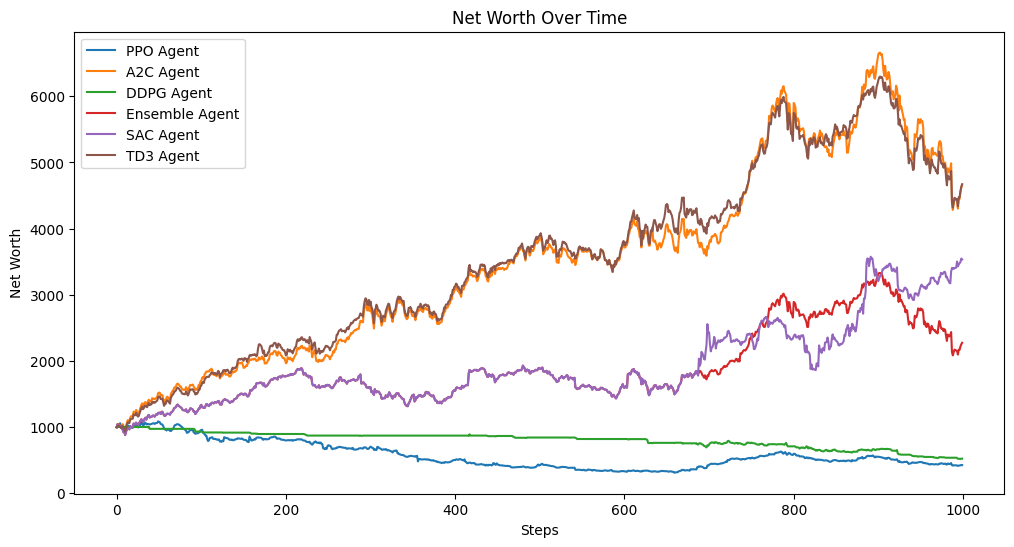

In [29]:
total_timesteps = 10000
env, ppo_agent, a2c_agent, ddpg_agent, ensemble_agent, sac_agent, td3_agent = create_env_and_train_agents(training_data, total_timesteps)

# 2. Test & visualize the agents
n_tests = 1000
agents = {
    'PPO Agent': ppo_agent,
    'A2C Agent': a2c_agent,
    'DDPG Agent': ddpg_agent,
    'Ensemble Agent': ensemble_agent,
    'SAC Agent': sac_agent,
    'TD3 Agent': td3_agent
}
test_and_visualize_agents(env, agents, training_data, n_tests=n_tests)


# Testing Model - Ensemble + PPO + A2C + DDPG

Testing PPO Agent...
Done testing PPO Agent!
Testing A2C Agent...
Done testing A2C Agent!
Testing DDPG Agent...
Done testing DDPG Agent!
Testing Ensemble Agent...
Done testing Ensemble Agent!
Testing SAC Agent...
Done testing SAC Agent!
Testing TD3 Agent...
Done testing TD3 Agent!
--------------------------------------------------
All agents tested!
--------------------------------------------------


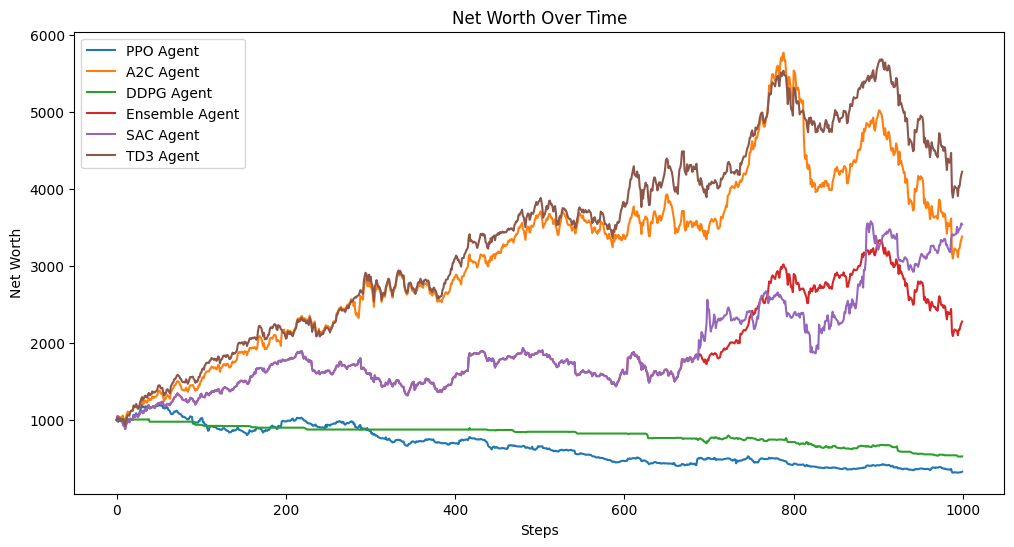

,Agent,Return,Standard Deviation,Sharpe Ratio
5,TD3 Agent,0.001555,0.017039,0.091232
1,A2C Agent,0.001436,0.018714,0.076733
4,SAC Agent,0.001498,0.021596,0.069382
3,Ensemble Agent,0.000994,0.018282,0.054376
0,PPO Agent,-0.000677,0.018418,-0.036738
2,DDPG Agent,-0.000627,0.007064,-0.088760


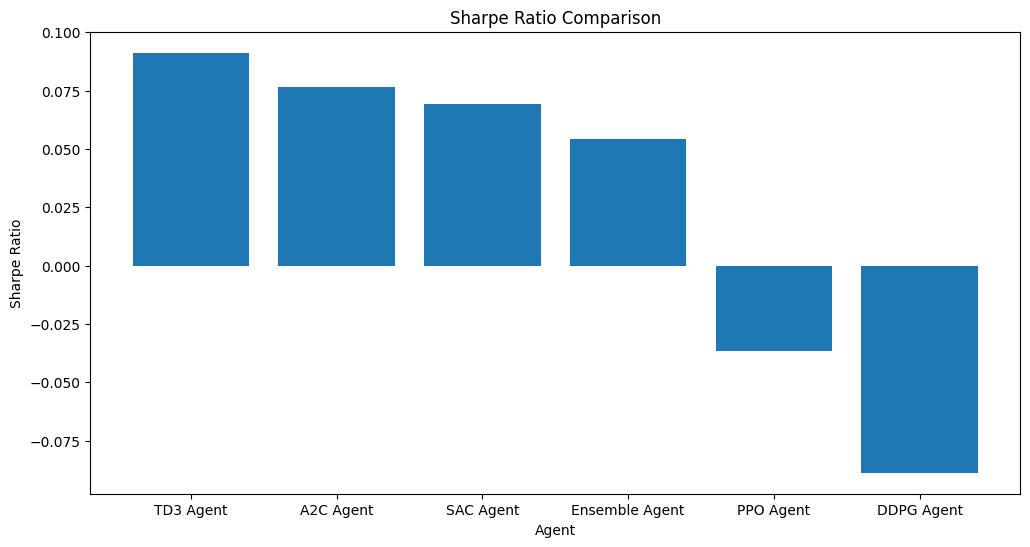

In [30]:
test_env = DummyVecEnv([lambda: StockTradingEnv(test_data)])

# 2. Test & visualize the agents on the test data
n_tests = 1000
test_agents = {
    'PPO Agent': ppo_agent,
    'A2C Agent': a2c_agent,
    'DDPG Agent': ddpg_agent,
    'Ensemble Agent': ensemble_agent,
    'SAC Agent': sac_agent,
    'TD3 Agent': td3_agent
}
test_and_visualize_agents(env, test_agents, test_data, n_tests=n_tests)

# 3. Compare the agents' performance on the test data ( returns, standard deviation, and sharpe ratio )
test_agents_metrics = [test_agent(env, agent, test_data, n_tests=n_tests, visualize=False) for agent in test_agents.values()]
compare_and_plot_agents(test_agents_metrics, list(test_agents.keys()))
